# COVID-19 Vaccine Time Series Analysis
**Authors:** Benjamin Mario Sainz-Tinajero, Dachely Otero Argote, and Carmen Elisa Orozco Mora  
**Paper title:** "A COVID-19 Macro Time Series Analysis of Vaccine Impact"  
**Repository:** github.com/benjaminsainz/covid-19-vaccine-tsa

## Data preparation
### Days that a vaccine is applied at least in one country
First, the vaccine dataset is loaded to a pandas DataFrame and as a country might use multiple vaccines, we melt the DataFrame to group by vaccine and count the number of days in which it has been used.

In [1]:
import pandas as pd

vacc = pd.read_csv('world_vaccination_preda_clean.csv')

pres = vacc[['date','vaccines_1', 'vaccines_2', 'vaccines_3', 'vaccines_4']] # presence
pres.set_index('date', inplace=True)
pres = pd.melt(pres, value_name='vaccine', ignore_index=False).drop('variable', axis=1).dropna()
pres.reset_index(inplace=True)
pres.set_index(['date', 'vaccine'], inplace=True)
pres['countries_applied'] = 1
pres = pres.groupby(['date', 'vaccine']).sum()
pres

daily = pres.reset_index().groupby('vaccine').count().sort_values('countries_applied', ascending=False)
daily.drop('date', axis=1).rename({'countries_applied':'days_applied'}, axis=1).iloc[:5,:]

,days_applied
vaccine,
Johnson&Johnson,131
Moderna,131
Oxford/AstraZeneca,131
Pfizer/BioNTech,131
Sinovac,114


### Number of countries that have used a vaccine
A similar approach is performed to find out how many countries have applied each vaccine, but this time, a simple count of the countries is needed to answer this question.

In [2]:
vacc = pd.read_csv('world_vaccination_preda_clean.csv')

pres = vacc[['iso_code','vaccines_1', 'vaccines_2', 'vaccines_3', 'vaccines_4']] # presence
pres.set_index('iso_code', inplace=True)
pres = pd.melt(pres, value_name='vaccine', ignore_index=False).drop('variable', axis=1).dropna()
pres = pres.reset_index().drop_duplicates().groupby(['vaccine']).count().sort_values('iso_code', ascending=False).iloc[:5,:]
pres

,iso_code
vaccine,
Oxford/AstraZeneca,91
Pfizer/BioNTech,88
Moderna,41
Sinopharm/Beijing,26
Sinovac,21


### Top 5 vaccines
We selected the vaccines by Oxford/Astra-Zeneca, Pfizer/BioNTech, Moderna, Johnson&Johnson, and Sinovac for further analysis. This decision is likely to be changed as the vaccination and pandemic status keeps changing over time.

In [3]:
top_vacc = ['Oxford/AstraZeneca', 'Pfizer/BioNTech', 'Moderna', 'Johnson&Johnson', 'Sinovac']

### Countries using top 5 vaccines
Now, we create a dictionary storing all of the countries using each vaccine. A country might appear in more than one vaccine key.

In [4]:
vacc = pd.read_csv('world_vaccination_preda_clean.csv')

cou = vacc[['country','vaccines_1', 'vaccines_2', 'vaccines_3', 'vaccines_4']] # presence
cou.set_index('country', inplace=True)
cou = pd.melt(cou, value_name='vaccine', ignore_index=False).drop('variable', axis=1).dropna()
cou.reset_index(inplace=True)
cou = cou[cou['vaccine'].isin(top_vacc)].drop_duplicates()

top_vacc_countries = dict()
for vacc in top_vacc:
    temp = cou[cou['vaccine']==vacc]
    top_vacc_countries[vacc] = temp['country'].to_list()

top_vacc_countries

{'Oxford/AstraZeneca': ['Albania',
  'Andorra',
  'Anguilla',
  'Argentina',
  'Azerbaijan',
  'Bahrain',
  'Bangladesh',
  'Bolivia',
  'Bosnia and Herzegovina',
  'Brazil',
  'Cambodia',
  'Cayman Islands',
  'Colombia',
  'Costa Rica',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Falkland Islands',
  'Grenada',
  'Guernsey',
  'Guyana',
  'Indonesia',
  'Iran',
  'Isle of Man',
  'Jersey',
  'Lebanon',
  'Maldives',
  'Moldova',
  'Mongolia',
  'Montenegro',
  'Montserrat',
  'Morocco',
  'Myanmar',
  'Namibia',
  'Northern Cyprus',
  'Oman',
  'Panama',
  'Peru',
  'Philippines',
  'Saint Helena',
  'Saint Kitts and Nevis',
  'Serbia',
  'Seychelles',
  'Sierra Leone',
  'Slovenia',
  'South Korea',
  'Sri Lanka',
  'Suriname',
  'Sweden',
  'Thailand',
  'Trinidad and Tobago',
  'Ukraine',
  'United Arab Emirates',
  'Uruguay',
  'Bulgaria',
  'Canada',
  'Croatia',
  'Denmark',
  'England',
  'Estonia',
  'Finland',
  'Greece',
  'Guatemala',
  'Honduras

### Time series generation
In this section, we load a cases DataFrame and find the countries that use each of the five selected vaccines. The last 21 days are used for testing later on and the remaining entries are stored in training time series.

In [5]:
cases = pd.read_csv('daily_updates_preda_clean.csv')

astra_zeneca = cases[cases['Country/Region'].isin(top_vacc_countries['Oxford/AstraZeneca'])]
astra_zeneca = astra_zeneca.groupby('Date').sum()[['Confirmed']]
astra_zeneca_train = astra_zeneca[:-21]
astra_zeneca_test = astra_zeneca[-21:]

pfizer = cases[cases['Country/Region'].isin(top_vacc_countries['Pfizer/BioNTech'])]
pfizer = pfizer.groupby('Date').sum()[['Confirmed']]
pfizer_train = pfizer[:-21]
pfizer_test = pfizer[-21:]

moderna = cases[cases['Country/Region'].isin(top_vacc_countries['Moderna'])]
moderna = moderna.groupby('Date').sum()[['Confirmed']]
moderna_train = moderna[:-21]
moderna_test = moderna[-21:]

johnson = cases[cases['Country/Region'].isin(top_vacc_countries['Johnson&Johnson'])]
johnson = johnson.groupby('Date').sum()[['Confirmed']]
johnson_train = johnson[:-21]
johnson_test = johnson[-21:]

sinovac = cases[cases['Country/Region'].isin(top_vacc_countries['Sinovac'])]
sinovac = sinovac.groupby('Date').sum()[['Confirmed']]
sinovac_train = sinovac[:-21]
sinovac_test = sinovac[-21:]

vacc_train = [astra_zeneca_train, pfizer_train, moderna_train, johnson_train, sinovac_train]
vacc_test = [astra_zeneca_test, pfizer_test, moderna_test, johnson_test, sinovac_test]
data = dict()
data['astra_zeneca'] = astra_zeneca
data['pfizer'] = pfizer
data['moderna'] = moderna
data['johnson'] = johnson
data['sinovac'] = sinovac

### Visualization of the five vaccine time series decomposition
A decomposition is useful for analyzing the observed cases, its seasonality, trend and residuals.

<ipython-input-6-abaede0545d9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v['Date'] = pd.to_datetime(v['Date'])
<ipython-input-6-abaede0545d9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v['Date'] = pd.to_datetime(v['Date'])
<ipython-input-6-abaede0545d9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

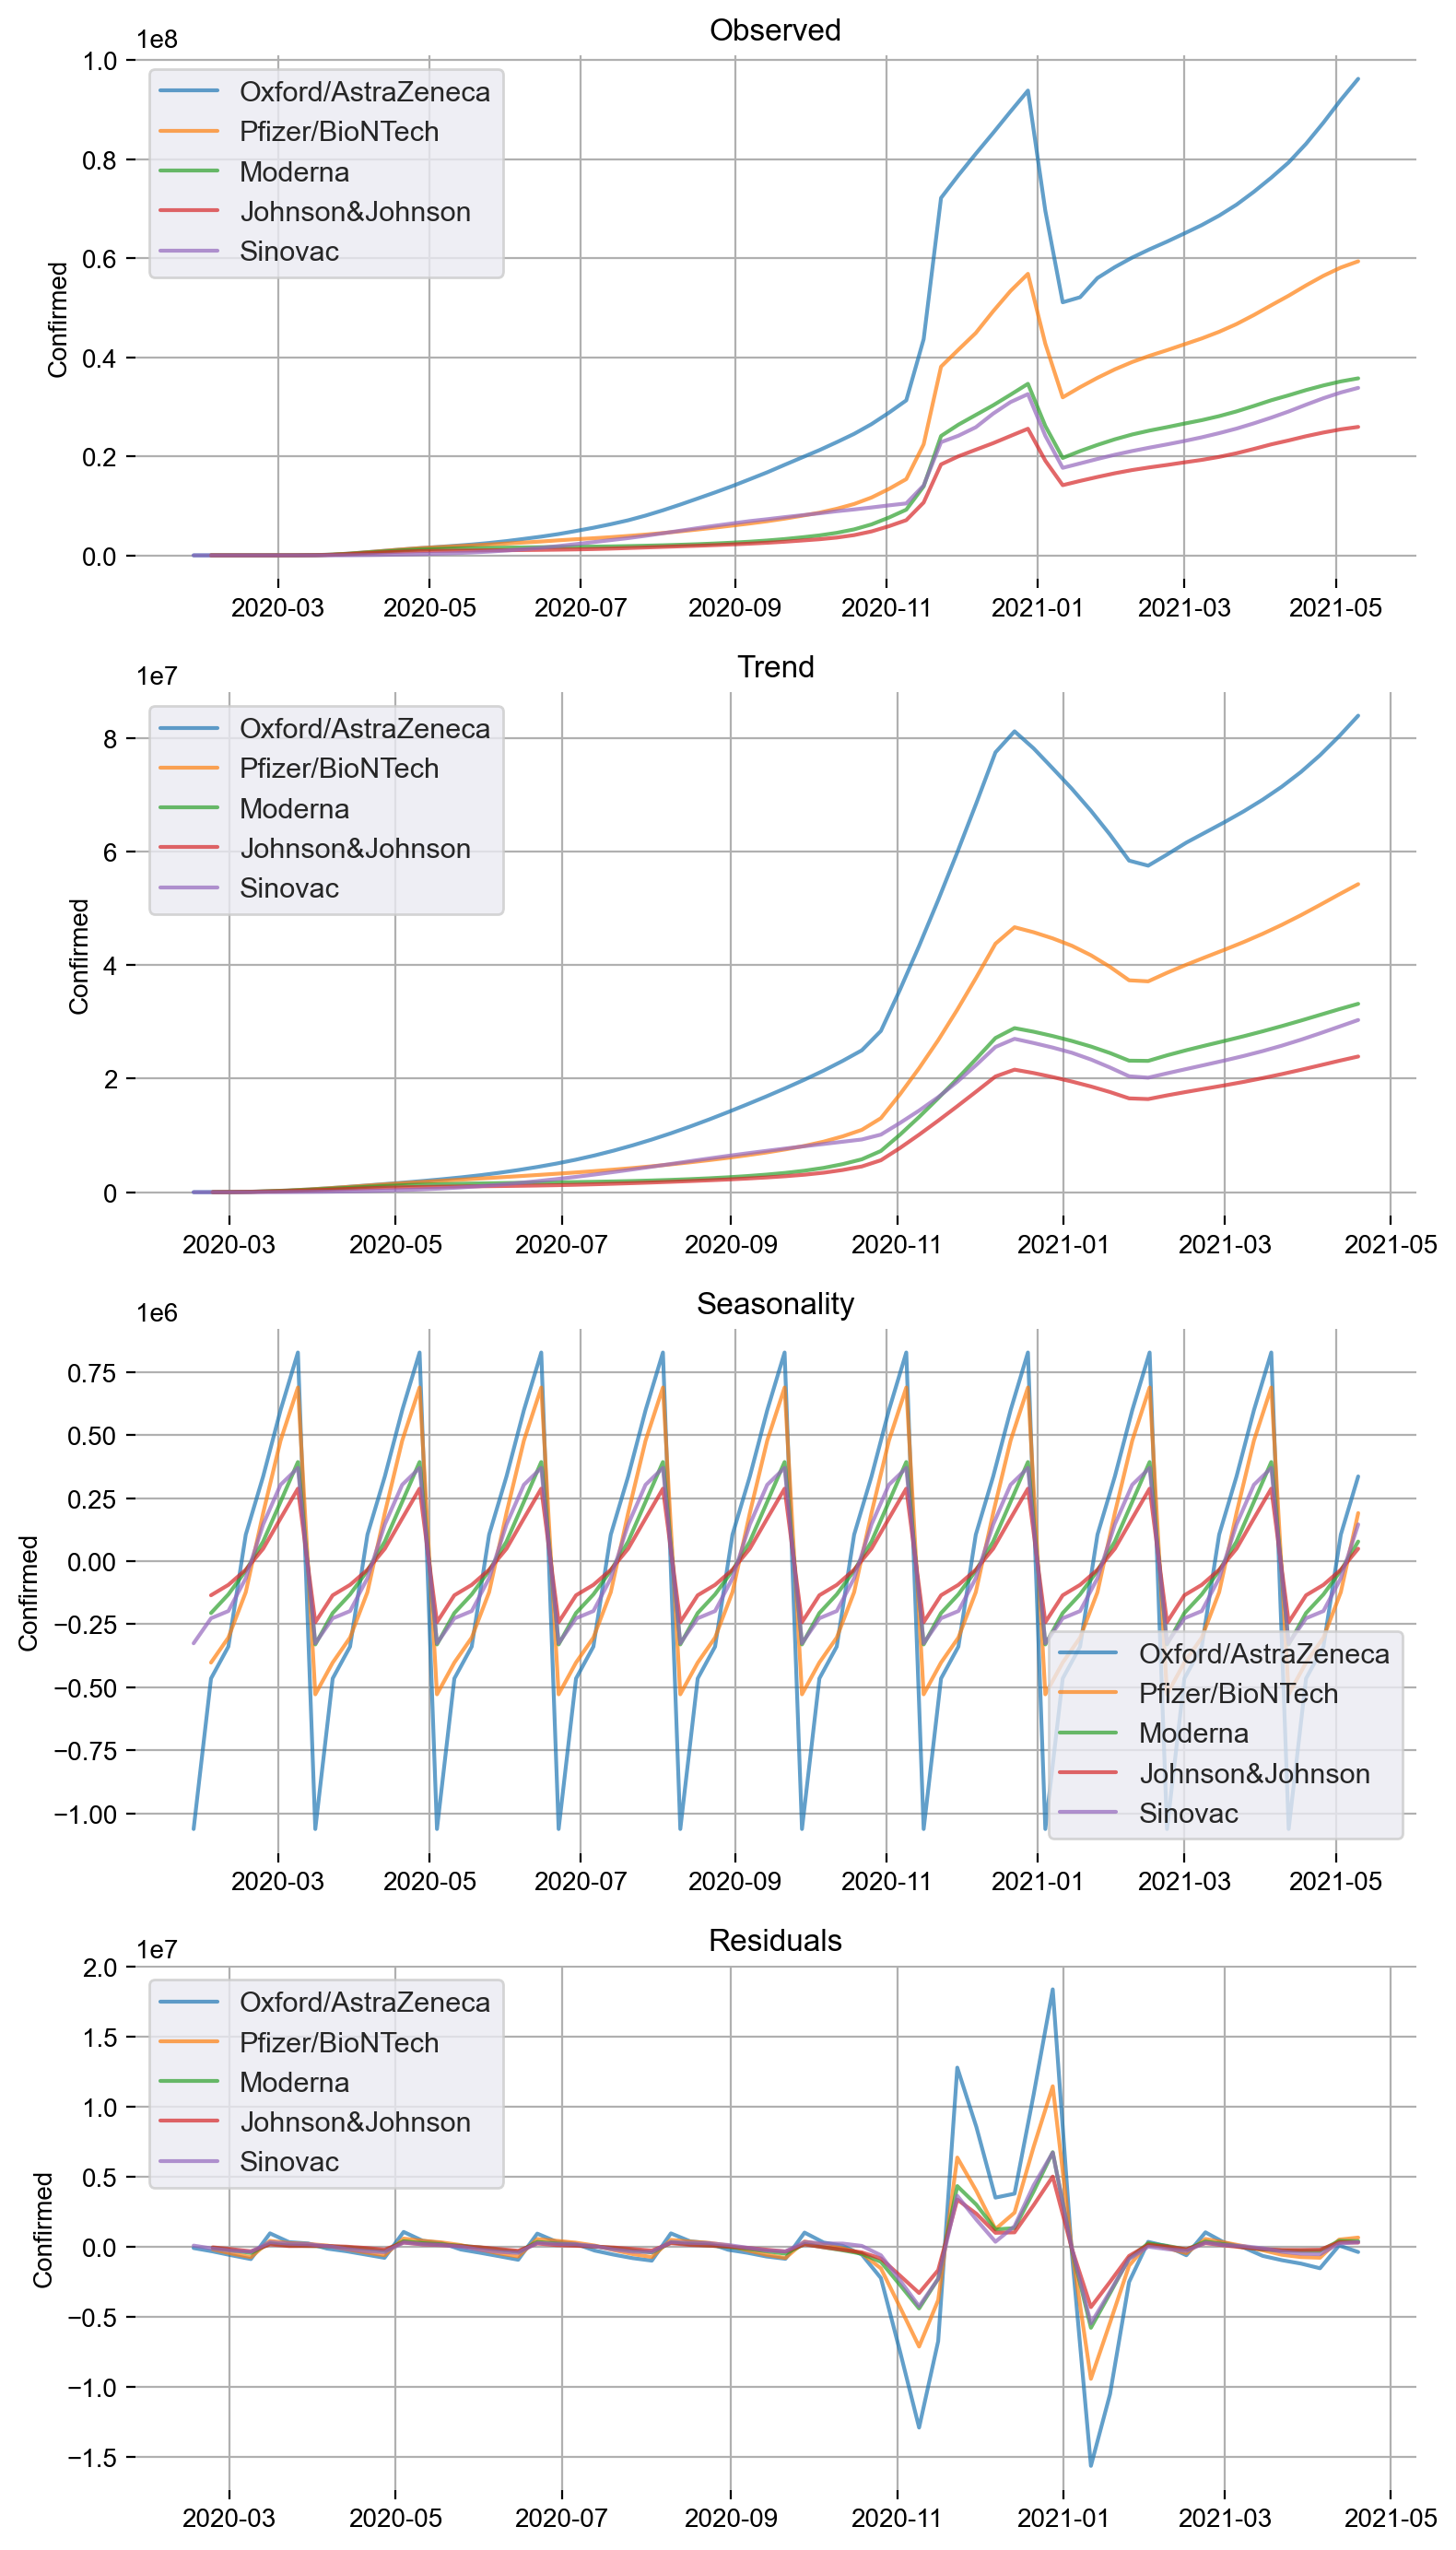

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(4, figsize=(8,14), dpi=200)
sns.set_theme()
sns.color_palette('muted')

i=0
for v in vacc_train:
    v.reset_index(inplace=True)
    v['Date'] = pd.to_datetime(v['Date'])
    v.set_index('Date', inplace=True)
    v.sort_index(axis=0, inplace=True)
    temp = v.resample('W-MON').mean()
    decomposition = seasonal_decompose(temp, period=7)
    
    df = pd.DataFrame(index=decomposition.observed.index)
    df['observed'] = decomposition.observed
    df['trend'] = decomposition.trend
    df['seasonality'] = decomposition.seasonal
    df['residuals'] = decomposition.resid
    
    sns.lineplot(data=df.reset_index(), x='Date', y='observed', alpha=0.7, label=top_vacc[i], ax=axs[0])
    sns.lineplot(data=df.reset_index(), x='Date', y='trend', alpha=0.7, label=top_vacc[i], ax=axs[1])
    sns.lineplot(data=df.reset_index(), x='Date', y='seasonality', alpha=0.7, label=top_vacc[i], ax=axs[2])
    sns.lineplot(data=df.reset_index(), x='Date', y='residuals', alpha=0.7, label=top_vacc[i], ax=axs[3])
    i+=1

for i in range(len(axs)):
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Confirmed')
    axs[i].grid(True)
    axs[i].legend()
    
axs[0].title.set_text('Observed')
axs[1].title.set_text('Trend')
axs[2].title.set_text('Seasonality')
axs[3].title.set_text('Residuals')

plt.tight_layout()
sns.despine(left=True, bottom=True)
# fig.savefig('decomposition_per_vaccine.eps', format='eps', dpi=1200)

## Modeling
In this block, we iterate through multiple parameters for finding the ARIMA models with the lowest AIC and BIC.

In [7]:
from statsmodels.tsa.arima.model import ARIMA 
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import itertools

vaccine_train = dict()
vaccine_train['astra_zeneca'] = astra_zeneca_train
vaccine_train['pfizer'] = pfizer_train
vaccine_train['moderna'] = moderna_train
vaccine_train['johnson'] = johnson_train
vaccine_train['sinovac'] = sinovac_train
vaccine_params = dict()

for v in vaccine_train:
    v_metrics = dict()
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p,d,q))]

    for param in pdq:
        for param_seasonal in seasonal_pdq: 
            v_model= ARIMA(vaccine_train[v],
                           order=param,
                           seasonal_order=param_seasonal,
                           enforce_stationarity=False,
                           enforce_invertibility=False).fit()
            v_metrics['{}-{}'.format(param, param_seasonal)] = v_model.aic, v_model.bic
    best_params= min(v_metrics, key=v_metrics.get)
    best_aic = v_metrics[best_params][0]
    best_bic = v_metrics[best_params][1]
    vaccine_params[v] = (best_params, best_aic, best_bic)
    print('{} ARIMA Model with best metrics: {}. AIC: {:.4f}, BIC: {:.4f}'.format(v, 
                                                                                  best_params, 
                                                                                  best_aic,
                                                                                  best_bic))

astra_zeneca ARIMA Model with best metrics: (0, 1, 0)-(1, 1, 1, 7). AIC: 14941.4585, BIC: 14953.8391
pfizer ARIMA Model with best metrics: (0, 1, 0)-(0, 1, 1, 7). AIC: 14119.2497, BIC: 14127.4593
moderna ARIMA Model with best metrics: (0, 1, 0)-(0, 1, 1, 7). AIC: 13682.2579, BIC: 13690.4674
johnson ARIMA Model with best metrics: (0, 1, 0)-(0, 1, 1, 7). AIC: 13413.6959, BIC: 13421.9055
sinovac ARIMA Model with best metrics: (0, 1, 0)-(0, 1, 1, 7). AIC: 13926.9017, BIC: 13935.1555


The obtained parameters are used for training the final set of ARIMA models.

In [8]:
models = dict()
for v in vaccine_train:
    models[v] = ARIMA(vaccine_train[v], order=(int(vaccine_params[v][0][1]),
                                          int(vaccine_params[v][0][4]),
                                          int(vaccine_params[v][0][7])),
                                seasonal_order=(int(vaccine_params[v][0][11]),
                                                int(vaccine_params[v][0][14]), 
                                                int(vaccine_params[v][0][17]),
                                                int(vaccine_params[v][0][20])), 
                                 enforce_stationarity=False,enforce_invertibility=False).fit()

## Model Evaluation
Each of the models is tested using the holdout data, and the MSE and RMSE is printed.

In [9]:
import numpy as np

tests = dict()
tests['astra_zeneca'] = astra_zeneca_test
tests['pfizer'] = pfizer_test
tests['moderna'] = moderna_test
tests['johnson'] = johnson_test
tests['sinovac'] = sinovac_test

preds = dict()
for v in vaccine_train:
    pred = models[v].get_prediction(start=pd.to_datetime('2021-05-10'), end=pd.to_datetime('2021-05-30'), dynamic=False)
    forecast = pred.predicted_mean
    y_truth = tests[v]
    y_truth = np.array(y_truth.squeeze())
    mse = forecast.subtract(y_truth).pow(2).mean()
    
    df = pd.DataFrame(index=forecast.index)
    df['y_truth'] = y_truth
    df['predictions'] = np.array(forecast)
    preds[v] = df
    
    print('====={}====='.format(v))
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

=====astra_zeneca=====
The Mean Squared Error of our forecasts is 23635590710023.14
The Root Mean Squared Error of our forecasts is 4861644.86
=====pfizer=====
The Mean Squared Error of our forecasts is 1006122517487.95
The Root Mean Squared Error of our forecasts is 1003056.59
=====moderna=====
The Mean Squared Error of our forecasts is 67712033921.38
The Root Mean Squared Error of our forecasts is 260215.36
=====johnson=====
The Mean Squared Error of our forecasts is 39360015394.57
The Root Mean Squared Error of our forecasts is 198393.59
=====sinovac=====
The Mean Squared Error of our forecasts is 1809017984687.81
The Root Mean Squared Error of our forecasts is 1344997.39


Next, we plot visualizations of the complete time series, and their predictions using the five ARIMA models. A dotted line is used to distinguish between the training and testing data.

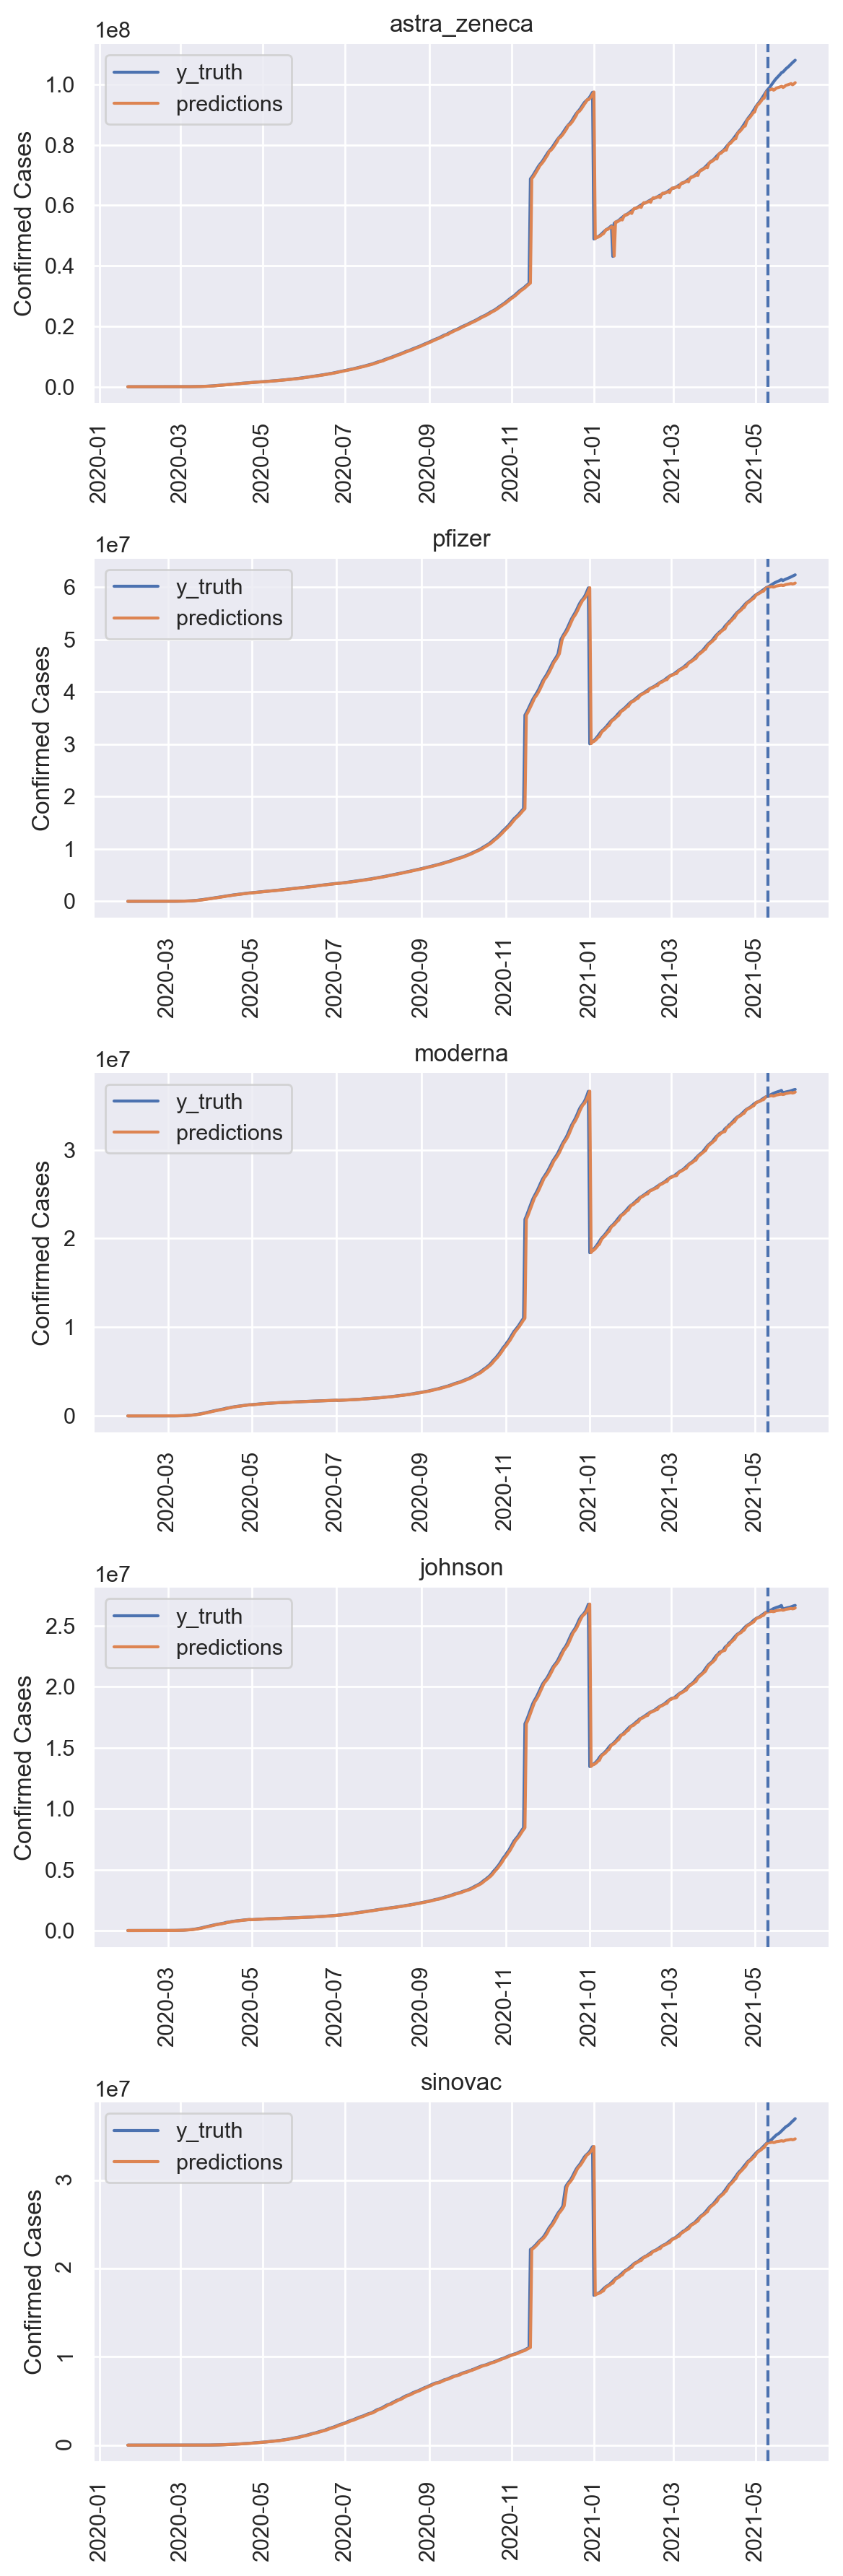

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 

sns.set_theme()
sns.color_palette('muted')

preds = dict()
for v in vaccine_train:
    pred = models[v].get_prediction(start=pd.to_datetime(data[v].iloc[0:1, :].index[0]), end=pd.to_datetime(data[v].last_valid_index()), dynamic=False)
    forecast = pred.predicted_mean
    y_truth = np.array(data[v])
    df = pd.DataFrame(index=forecast.index)
    df['y_truth'] = y_truth
    df['predictions'] = np.array(forecast)
    preds[v] = df

fig, axs = plt.subplots(5, 1, figsize=(6, 18), dpi=200)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
plt.yticks(rotation=90)

i=0
for v in preds:
    sns.lineplot(ax=axs[i], data=preds[v].melt(var_name='variable', ignore_index=False).reset_index(), x='index', y='value', hue='variable')
    axs[i].axvline(x=pd.to_datetime('2021-05-10'), linestyle='--')
    axs[i].set_title(v)
    axs[i].legend()
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Confirmed Cases')
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90)
    i+=1

plt.tight_layout()
sns.despine(left=True, bottom=True)
# fig.savefig('predictions_test.eps', format='eps', dpi=1200)
    

## Deployment
To make use of the methodology, we got predictions for 21 days after the last entry in the collected data, which are further used for training linear models for searching the smallest vaccine slope.

In [11]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

preds = dict()
reg_coeffs = dict()
for v in models:
    pred = models[v].get_prediction(start=pd.to_datetime('2021-05-30'), end=pd.to_datetime('2021-06-21'), dynamic=False)
    forecast = pred.predicted_mean    
    df = pd.DataFrame(index=forecast.index)
    df['ARIMA Predictions'] = np.array(forecast)
    preds[v] = df
    
    X = np.array(preds[v].reset_index().index).reshape(-1,1)
    y = np.array(preds[v]['ARIMA Predictions']).reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print('===={}===='.format(v))
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

    preds[v]['LR Predictions'] = reg.predict(X)
    reg_coeffs[v] = (reg.coef_[0][0], reg.score(X, y), reg.intercept_[0])
reg_coeffs

====astra_zeneca====
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     452.7
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           1.08e-15
Time:                        17:25:37   Log-Likelihood:                -310.66
No. Observations:                  23   AIC:                             625.3
Df Residuals:                      21   BIC:                             627.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.006e+08   7.51e+0

{'astra_zeneca': (124421.28853349622, 0.9556675766535652, 100553628.77128616),
 'pfizer': (41083.43240934344, 0.9725123589120342, 60728180.307912014),
 'moderna': (24423.82626146871, 0.9702985977701736, 36505334.794183545),
 'johnson': (16176.542286830316, 0.9698366611839065, 26466003.652921382),
 'sinovac': (22308.011768970242, 0.9723015377462607, 34671534.89886564)}

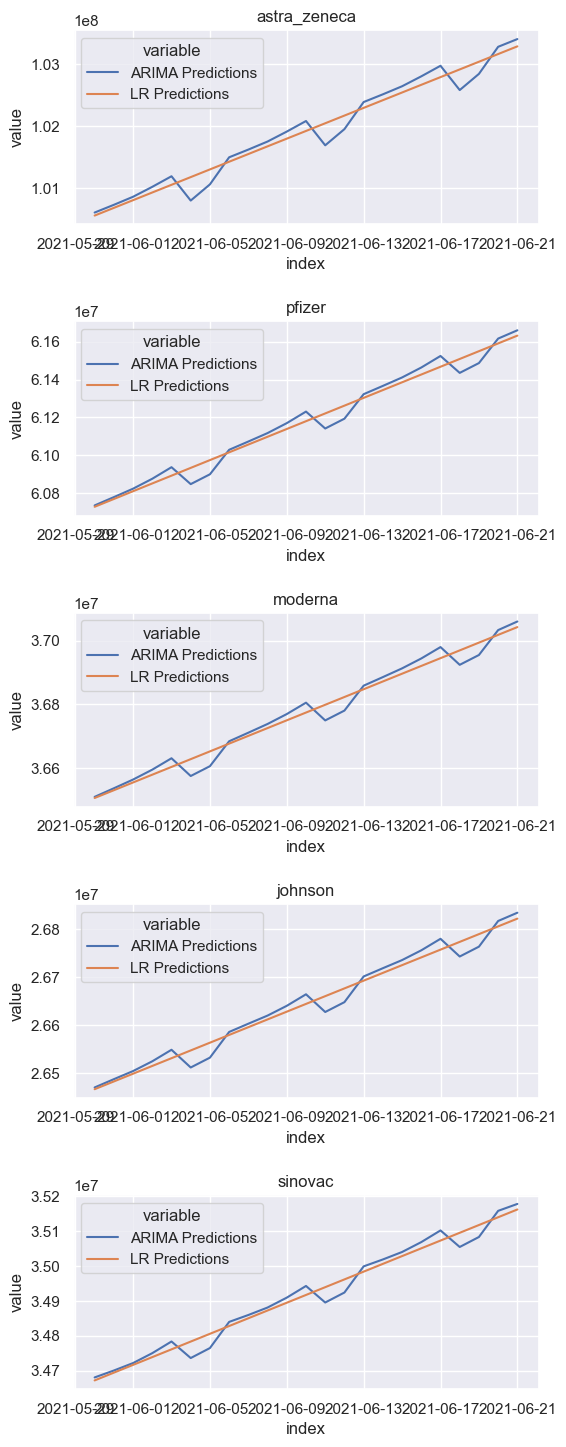

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(6, 18), dpi=100)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

i=0
for v in preds:
    sns.lineplot(ax=axs[i], data=preds[v].melt(var_name='variable', ignore_index=False).reset_index(), x='index', y='value', hue='variable')
    axs[i].set_title(v)
    i+=1

In [13]:
sorted(reg_coeffs, key=lambda k: reg_coeffs[k][0])

['johnson', 'sinovac', 'moderna', 'pfizer', 'astra_zeneca']

The plots and coefficients let us state that the Johnson&Johnson vaccine is related to the countries with the less steep slope of cases in the predicted days. This methodology is applicable for any set of countries or days, and it lets us state conclusions with confidence due to the set of methods involved.